#### Import library
- tensorflow
- layers
- models
- ImageDataGenerator

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
import pickle
import keras
from keras import ops
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

##### prepare data for training and testing

In [2]:
# Define your categories
CATEGORIES = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
CATEGORIESDIR = "D:\Github\colab_ml_model_learning/emotion_dataset/train"
IMG_SIZE = 224
training_data = []

for category in CATEGORIES:
    path = os.path.join(CATEGORIESDIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([new_array, class_num])
        except Exception as e:
            pass
# Shuffle the training data
np.random.shuffle(training_data)


# Separate features and labels
x = []
y = []

for features, label in training_data:
    x.append(features)
    y.append(label)

# Convert lists to numpy arrays
x = np.array(x).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y).reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

# Print the shapes of the arrays
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (22967, 224, 224, 3) - y_train shape: (22967, 1)
x_test shape: (5742, 224, 224, 3) - y_test shape: (5742, 1)


##### Use data augmentation

In [3]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization()
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

#### Configure Hyperparameters

In [57]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 30
image_size = 224
patch_size = 32
num_patches = (image_size // patch_size) ** 2

num_classes = len(CATEGORIES)
input_shape = (224, 224, 3)

projection_dim = 64
num_heads = 4
transformer_units = {
    projection_dim * 2,
    projection_dim,
}

transformer_layers = 8
mlp_head_units = [2048, 1024]


##### Implement multilayer perceptron (MLP)

In [58]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

##### Implement patch creation as a layer

In [59]:
class Patches(layers.Layer):
    def __init__(self, patch_size, dtype='float32', **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

##### Let's display patches for a sample image

Image size: 224 X 224
Patch size: 32 X 32
Patches per image: 49
Elements per patch: 3072


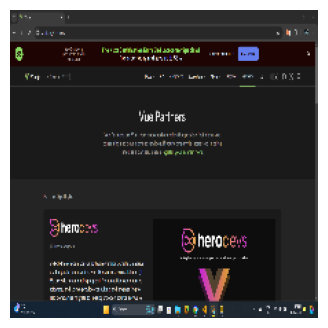

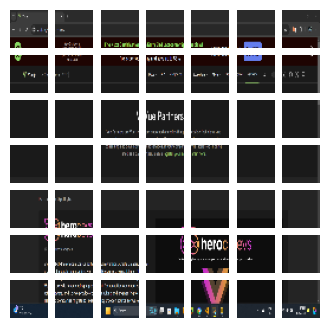

In [60]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

##### Implement the patch encoding layer
The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [61]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, dtype='float32', **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection.units  # Include projection_dim in the config
        })
        return config

##### Build the ViT model

In [62]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches) # 1
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1 # 2
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches]) # 3
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2) # 4
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1) # 5, 6
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2]) # 7

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

##### print parameters of this model

In [63]:
def print_model_parameters(model):
    print("Model Summary:")
    print(model.summary())

# Assuming `vit_classifier` is the VIT model
vit_classifier = create_vit_classifier()
print_model_parameters(vit_classifier)

Model Summary:


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          7 │ input_layer_5[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_6 (Patches) │ (None, 49, 3072)  │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_4     │ (None, 49, 64)    │    199,808 │ patches_6[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ patch_encoder_4[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_64 (Add)        │ (None, 49, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ add_64[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_82 (Dense)    │ (None, 49, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_117         │ (None, 49, 128)   │          0 │ dense_82[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_83 (Dense)    │ (None, 49, 64)    │      8,256 │ dropout_117[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_118         │ (None, 49, 64)    │          0 │ dense_83[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_65 (Add)        │ (None, 49, 64)    │          0 │ dropout_118[0][0… │
│                     │                   │            │ add_64[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ add_65[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_66 (Add)        │ (None, 49, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_65[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ add_66[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_84 (Dense)    │ (None, 49, 128)   │      8,320 │ layer_normalizat

 Total params: 9,390,345 (35.82 MB)

 Trainable params: 9,390,338 (35.82 MB)

 Non-trainable params: 7 (32.00 B)

None


##### Compile, train, and evaluate the mode

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.5498 - loss: 1.7079 - top-5-accuracy: 1.0000 - val_accuracy: 0.7812 - val_loss: 1.4746 - val_top-5-accuracy: 1.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7121 - loss: 3.8036 - top-5-accuracy: 1.0000 - val_accuracy: 0.3438 - val_loss: 3.4719 - val_top-5-accuracy: 1.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.5955 - loss: 2.1833 - top-5-accuracy: 1.0000 - val_accuracy: 0.9062 - val_loss: 1.9830 - val_top-5-accuracy: 1.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7368 - loss: 4.5793 - top-5-accuracy: 1.0000 - val_accuracy: 0.8125 - val_loss: 0.4893 - val_top-5-accuracy: 1.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7183 - loss: 1.3576 - top-5-accuracy: 1.0000 - val_accuracy: 0.0938 - val_loss: 2.5972 - val_top-5-accuracy: 1.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4971 - loss: 1.2542 - top-5-accuracy: 1.0000 - val_a

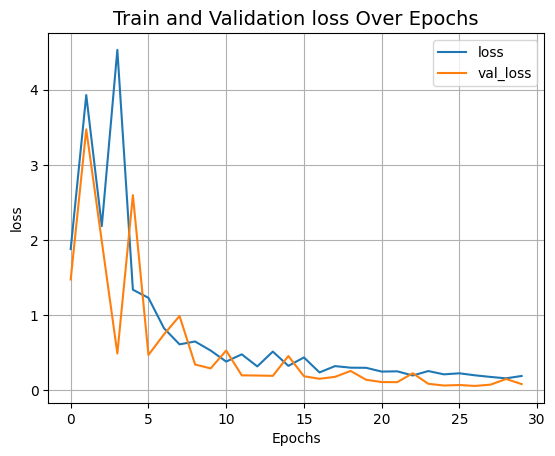

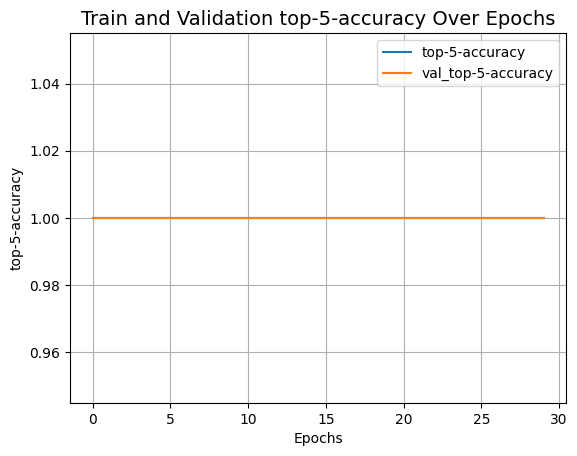

In [64]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")

In [65]:
# Define the path where you want to save the model
model_save_path = "./model/vit_model_v2.keras"

# Save the model
vit_classifier.save(model_save_path)

print("Model saved successfully at:", model_save_path)


Model saved successfully at: ./model/vit_model_v2.keras


In [66]:
from tensorflow.keras.models import load_model

model_path = "./model/vit_model_v2.keras"
loaded_model = load_model(model_path, custom_objects={"Patches": Patches, "PatchEncoder": PatchEncoder})


d:\Github\colab_ml_model_learning\vitou_env\lib\site-packages\keras\src\layers\layer.py:361: UserWarning: `build()` was called on layer 'patch_encoder_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [67]:
from sklearn.preprocessing import LabelEncoder

# Define labels and initialize LabelEncoder
labels = ['enjoying', 'studying']
label_encoder = LabelEncoder()

# Fit and transform labels
encoded_labels = label_encoder.fit_transform(labels)

# Load the model
# Assuming you have already loaded your model as 'loaded_model'

# Define the directory
image_dir = "D:/Github/colab_ml_model_learning/validation_img"

# List all files in the directory
image_files = os.listdir(image_dir)

# Iterate through each image
for image_file in image_files:
    # Read the image
    image_path = os.path.join(image_dir, image_file)
    # Read the image
    image = cv2.imread(image_path)

    # Resize the image to match the expected input shape of the model
    resized_image = cv2.resize(image, (224, 224))

    # Preprocess the image (normalize, etc.)
    # Add your preprocessing steps here

    # Make prediction
    prediction = loaded_model.predict(np.expand_dims(resized_image, axis=0))

    print(prediction)
    # Convert predictions to labels
    predicted_labels = label_encoder.inverse_transform(prediction.argmax(axis=1))

    # Printing predicted labels
    print(f"Prediction for {image_file}: {predicted_labels}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[ 0.6962696 -1.508117 ]]
Prediction for enjoy.png: ['enjoying']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
[[ 1.5417464 -2.8525312]]
Prediction for enjoy_img_1.png: ['enjoying']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
[[ 1.0238717 -1.5567232]]
Prediction for game.png: ['enjoying']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
[[-3.0214741  1.9617498]]
Prediction for study_img_1.png: ['studying']
